# Rayleigh-Benard convection

Learn normal form for onset of rolls

In [543]:
import numpy as np
import numpy.random as rng
import sys
sys.path.append('../src')

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

from scipy import linalg
import scipy.io as sio
from scipy.integrate import solve_ivp

import sympy as sym

from sindy import *

# Load dimensionless data

In [544]:
data = sio.loadmat('../data/RB_data.mat')
keys = [key for key in data.keys() if key[:2] == 'Ra']

train_keys = [key for key in keys if (int(key[2:6]) >= 1850) and (int(key[2:6]) <= 1900)]
test_keys = [key for key in keys if key not in train_keys]

In [545]:
tau_list = []
CQ_list = []
Ra_list = []
Pr_list = []
for key in train_keys:
    tau_list.append( data[key]['t'][0][0].flatten() )
    CQ_list.append( abs( data[key]['Qhat'][0][0].flatten() ) )
    Ra_list.append( data[key]['Ra'][0][0][0, 0] )
    Pr_list.append( data[key]['Pr'][0][0][0, 0] )
    
dCQ_list = [np.gradient(CQ_list[idx], tau_list[idx][1]-tau_list[idx][0]) for idx in range(len(CQ_list))]

# Also load test data
tau_test = []
Ra_test = []
Pr_test = []
CQ_test = []
for key in test_keys:
    tau_test.append( data[key]['t'][0][0].flatten() )
    CQ_test.append( abs( data[key]['Qhat'][0][0].flatten() ) )
    Ra_test.append( data[key]['Ra'][0][0][0, 0] )
    Pr_test.append( data[key]['Pr'][0][0][0, 0] )

In [546]:
Ra_list

[1850, 1860, 1870, 1880, 1890, 1900]

### Plot dimensionless results

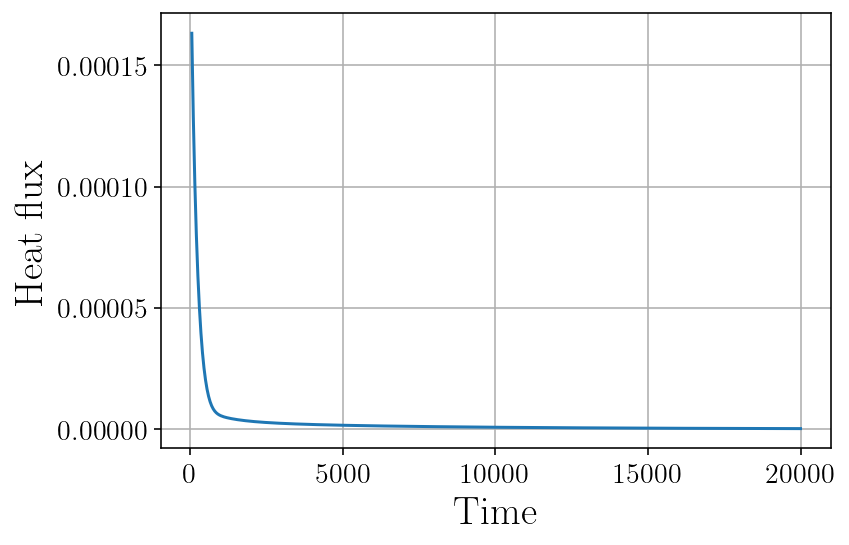

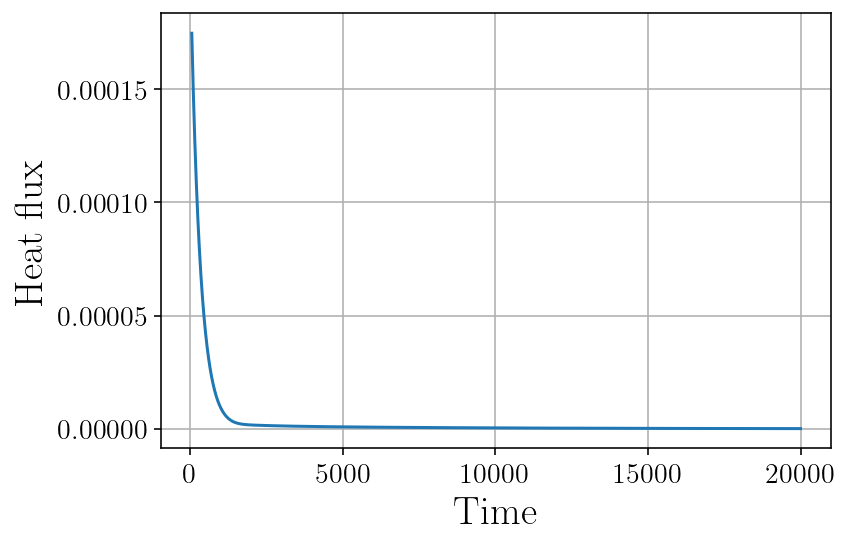

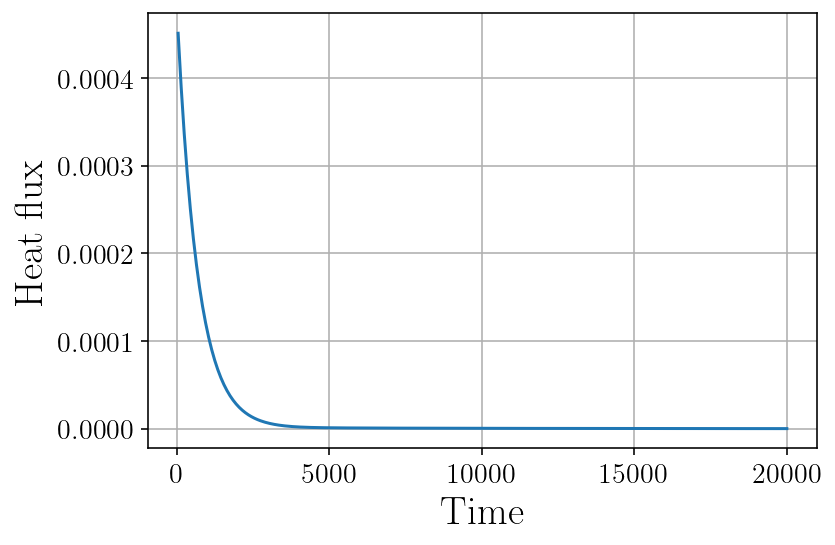

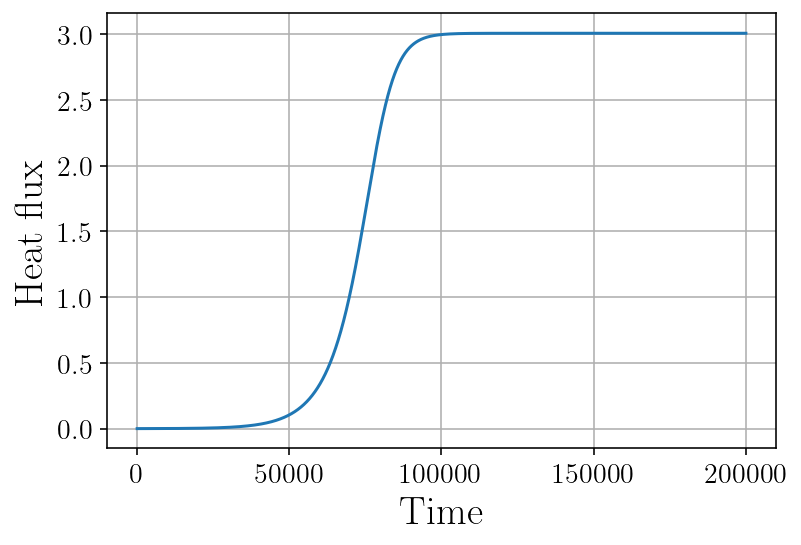

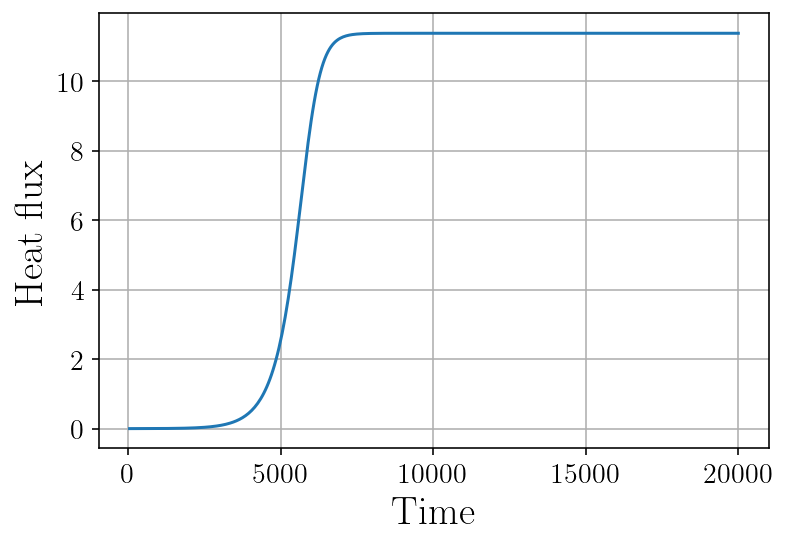

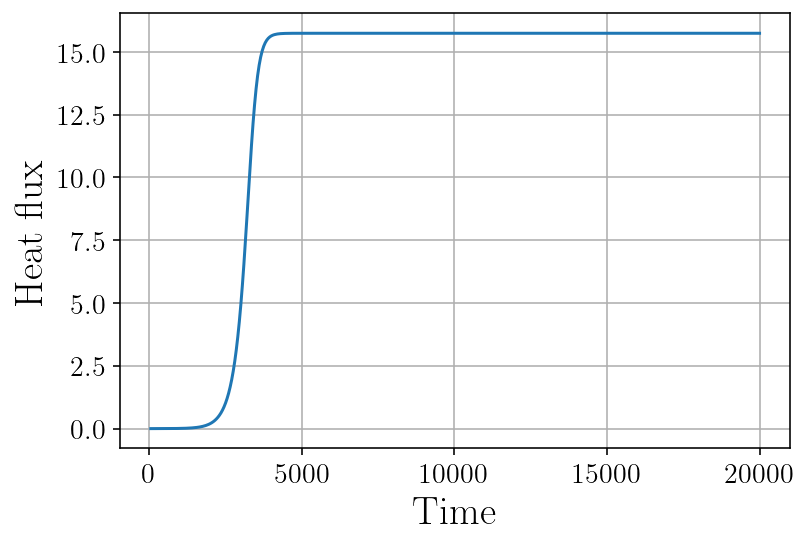

In [547]:
for (tau, CQ) in zip(tau_list, CQ_list):
    plt.plot(tau, CQ)
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Heat flux')
    #plt.xlim([0, 20000])
    plt.show()
plt.show()

# Set up the problem

There are a couple of classes for dealing with the data: a Quantity, which stores the name and vector of dimensional exponents, and a System, which keeps a list of "parameters" and a second list of "quantities of interest".  Generally, the quantities are the input/output variables and the parameters are the modifiers of the input/output relationship.  The System class also has a number of utility functions (like stacking the parameters or dimensional exponent vectors into matrices).

In [548]:
# Dimension vector: [length, temperature, time]
param_list = [
    Quantity('H', [1, 0, 0]),
    Quantity('g', [1, 0, -2]),
    Quantity('alpha', [1, -1, 0], sym_name=r'\alpha'),
    Quantity('dT', [0, 1, 0]),
    Quantity('nu', [2, 0, -1], sym_name=r'\nu'),
    Quantity('kappa', [2, 0, -1], sym_name=r'\kappa')
]

qty_list = [
    Quantity('t', [0, 0, 1]),
    Quantity('q', [0, 0, 0])
]


Since we only have simulation data here, we'll assign arbitrary dimensional values to the variables, keeping them consistent with the Rayleigh and Prandtl numbers of the simulation.  The numbers are chosen to be similar to something like water.

To avoid having very long time series near the bifurcation, truncate long data series.  Note this is a bit of a workaround; a better way would be to have a principled way to weight the different experiments appropriately.

In [549]:
RayleighBenard = System(qty_list, param_list)

seed = np.random.randint(low=0, high=2**32-1)
print(seed)
rng = np.random.RandomState(seed)

t_len = min([len(t) for t in tau_list])  # Truncate so all time series have same length
print(t_len)

kap = 0.5
dT = 50
alpha = 1e-4

g = 9.8
        
for (Pr, Ra, tau, Q) in zip(Pr_list, Ra_list, tau_list, CQ_list):
    nu = kap*Pr
    H = np.sqrt(nu*kap*Ra/(g*alpha*dT))

    # Dimensionalize time
    t = np.sqrt(H/(g*alpha*dT))*tau
#         Q = kap*dT*Q  # If we were to dimensionalize Q

    # Nondimensional quantities and time
    dQ = np.gradient(Q, t[1]-t[0])

    RayleighBenard.add_expt(
        q = {'q': (Q[:t_len], dQ[:t_len]), 't': t[:t_len]},
        p = {'H': H, 'g': g, 'alpha': alpha, 'dT': dT, 'nu': nu, 'kappa': kap}
    )
        

# Same thing to generate "test" data
RBTest = System(qty_list, param_list)
for (Pr, Ra, tau, Q) in zip(Pr_test, Ra_test, tau_test, CQ_test):
    nu = kap*Pr
    H = np.sqrt(nu*kap*Ra/(g*alpha*dT))

    # Dimensionalize time
    t = np.sqrt(H/(g*alpha*dT))*tau
#         Q = kap*dT*Q  # If we were to dimensionalize Q

    # Nondimensional quantities and time
    dQ = np.gradient(Q, t[1]-t[0])

    RBTest.add_expt(
        q = {'q': (Q[:t_len], dQ[:t_len]), 't': t[:t_len]},
        p = {'H': H, 'g': g, 'alpha': alpha, 'dT': dT, 'nu': nu, 'kappa': kap}
    )
        

3354343769
400


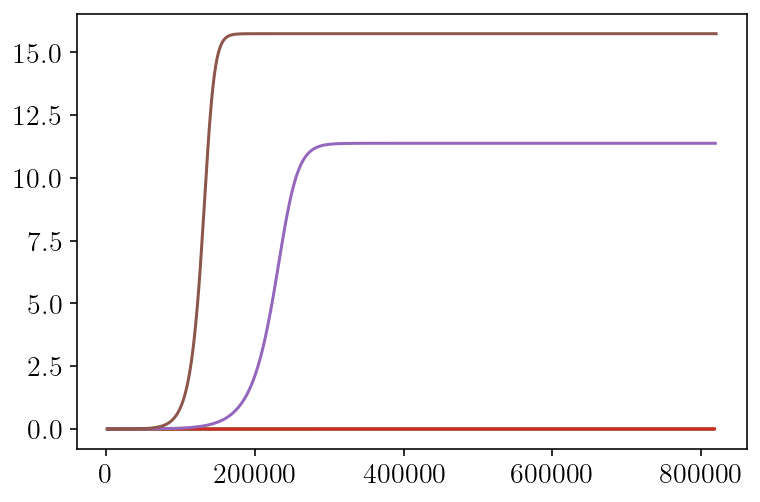

In [550]:
for expt in RayleighBenard.expts:
    Q, dQ = expt['q']
    plt.plot(expt['t'], Q)

We have to define a custom function to take the Experiment object and convert it to numpy arrays that can be stacked for the linear algebra problem.  Although this could in theory be automated, a custom definition allows for things like appropriately scaling second-order systems, flexible scaling of the quantities of interest, relative weighting of experiments, etc.

In [551]:
def vectorize(expt, pi):
    """
    For a given candidate scaling, generate numpy arrays for
      input vectors (y), scaled derivatives (dy), and relative weights (w)
      
    In this case, we expect that the first entry of the dimensionless groups will be the timescale
      and that expt['q'] will be a tuple of (Q, dQ), where Q is the QoI and dQ is its (dimensional) derivative
    """
    T = pi[0]        # Timescale
    Q, dQ = expt['q']
    t = expt['t']    # Dimensional time
    
    y = Q[None, :]      # Integrated heat flux is already nondimensionalized in this case
    dy = T*dQ[None, :]  # Nondimensionalize derivative with timescale
    w = np.full(len(t), max(abs(dy)))  # Weight by maximum of LHS / number of samples
    p = np.vstack([ pi[1:] for i in range(len(t)) ]).T  # Each row is a dimensionless parameter
    
    return y, dy, p, w

Finally we can define a library of candidate functions.  Based on the symmetry of the system, here we'll just use a simple list of low-order polynomials in the QoI and parameter:

In [552]:
# Define candidate functions
q_fns = [lambda q: q[0],
         lambda q: q[0]**3,
        ]

p_fns = [lambda pi: 1+0*pi[0],
         lambda pi: pi[0]]

Theta = ParametricLibrary(q_fns, p_fns)

In [553]:
opt = STLSQ(threshold=1e-10, cond=None, max_iter=5, normalize=True)
model = DimensionlessSINDy(RayleighBenard, Theta, vectorize, opt=opt)
param_list, param_names, loss_list = model.fit_all_dynamics(loss=normalized_l2_loss)

In [554]:
from IPython.display import display, Math
sort_idx = np.argsort(loss_list)

for i in range(5):
    display(Math(sym.latex(param_names[sort_idx[i]])), Math)
    print('test loss = ', loss_list[sort_idx[i]])
    print('----------------------------')

<IPython.core.display.Math object>

IPython.core.display.Math

test loss =  0.030490434856747444
----------------------------


<IPython.core.display.Math object>

IPython.core.display.Math

test loss =  0.03049043485809685
----------------------------


<IPython.core.display.Math object>

IPython.core.display.Math

test loss =  0.0304904348586391
----------------------------


<IPython.core.display.Math object>

IPython.core.display.Math

test loss =  0.030490434858678098
----------------------------


<IPython.core.display.Math object>

IPython.core.display.Math

test loss =  0.030490434858794917
----------------------------


Text(0, 0.5, 'SINDy loss')

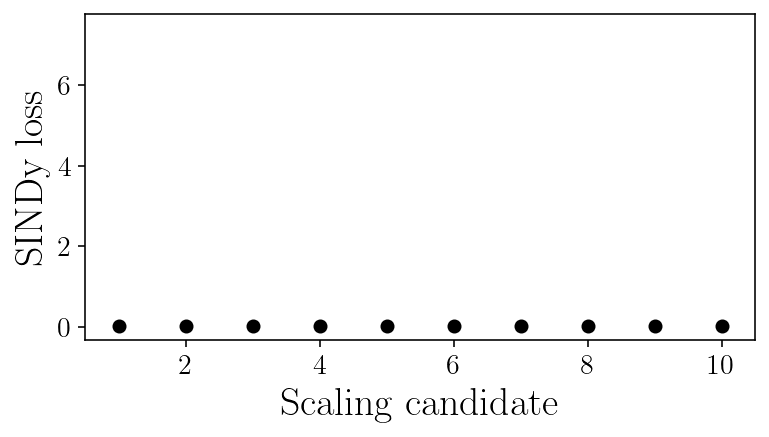

In [555]:
plt.figure(figsize=(6, 3))
plt.scatter(1+np.arange(len(loss_list)), loss_list[sort_idx], c='k')
plt.xlim([0.5, 10.5])
#plt.ylim([1e-4, 1e0])
plt.xlabel('Scaling candidate')
plt.ylabel('SINDy loss')

In [556]:
model_idx = 0
dim_vecs = param_list[sort_idx[model_idx]]

q, dq, p, w = model.vectorize_all(dim_vecs)

# Fit SINDy model
lib = Theta(q, p)
opt.threshold=1e-8
opt.fit(lib, dq.T)
Xi = opt.coef_[0, :]
Xi

array([ 7.71225461e-05,  0.00000000e+00, -6.19159174e-01, -1.38607320e-05])

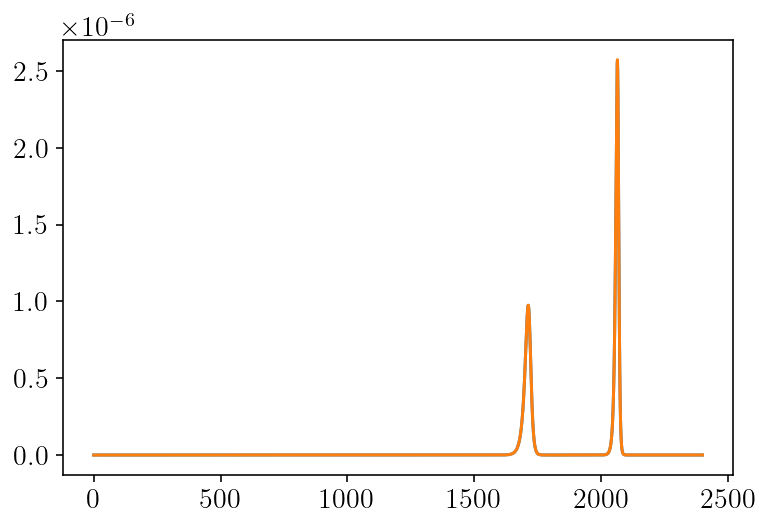

In [557]:
plt.plot(dq.T)
plt.plot(lib @ Xi)

In [558]:
lib = Theta(sym.symbols('q,'), sym.symbols('\pi_1,')).flatten('F')
expr = lib @ Xi
expr

-1.38607319886874e-5*\pi_1*q**3 - 0.619159173980806*\pi_1*q + 7.71225460689836e-5*q

In [559]:
Xi

array([ 7.71225461e-05,  0.00000000e+00, -6.19159174e-01, -1.38607320e-05])

In [560]:
Xi[2]/Xi[0]  # Critical Rayleigh number

-8028.251212388505

In [561]:
Xi[3]/Xi[2]  # Landau parameter

2.2386379094686648e-05

In [562]:
expr/Xi[2]

2.23863790946866e-5*\pi_1*q**3 + 1.0*\pi_1*q - 0.00012456012817049*q

### Test evaluation

In [563]:
idx = 5
expt = RayleighBenard.expts[idx]
T_vec, Q_vec = dim_vecs
Q, dQ = expt['q']
t = expt['t']
q0 = [abs( Q[0] )]
p_vec = RayleighBenard.param_vec(expt)
Pi_q = np.exp( np.log(p_vec) @ np.vstack(Q_vec) ).T
Pi_t = np.exp( np.log(p_vec) @ T_vec ).T  # Timescale

lib = Theta(sym.symbols('q,'), Pi_q).flatten('F')
expr = ( lib @ Xi ) / Pi_t
expr

-3.19699518534987e-7*q**3 + 7.92342180481109e-5*q

In [564]:
1/Pi_q  # Bifurcation parameter

array([8072.79381627])

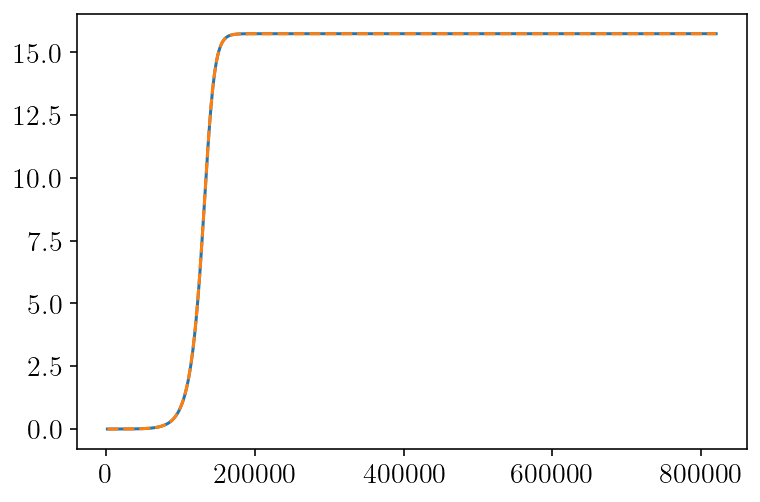

In [565]:
rhs = lambda t, q: (Theta([q], Pi_q).flatten('F') @ Xi) / Pi_t
t_span = (t[0], t[-1])
sol = solve_ivp(rhs, t_span, q0, rtol=1e-8, atol=1e-8)

plt.plot(t, Q)
plt.plot(sol.t, sol.y.T, '--')

# Find fixed points (bifurcation diagram)

In [566]:
T_vec, Q_vec = dim_vecs
Pi_q = np.array([])
for expt in RayleighBenard.expts:
    p_vec = RayleighBenard.param_vec(expt)
    Pi_q = np.append(Pi_q, np.exp( np.log(p_vec) @ np.vstack(Q_vec) ).T)
    
    
Pi_q_test = np.array([])
for expt in RBTest.expts:
    p_vec = RBTest.param_vec(expt)
    Pi_q_test = np.append(Pi_q_test, np.exp( np.log(p_vec) @ np.vstack(Q_vec) ).T)


# Bifurcation parameter is 1/pi_q (this will not necessarily be 1/Ra here)
mu = 1/Pi_q
mu_test = 1/Pi_q_test
mu

array([7965.86467372, 7987.36502233, 8008.80765158, 8030.19302383,
       8051.52159533, 8072.79381627])

In [567]:
from scipy.optimize import root

n_plt = 500
mu_plt = np.linspace(mu_test[0], mu_test[-1], n_plt)  # Bifurcation parameter
eq_plt = np.zeros(n_plt)
x0 = 100
for i in range(n_plt):
    Pi_q = [1/mu_plt[-(1+i)]]
    rhs = lambda q: (Theta([q], Pi_q).flatten('F') @ Xi)
    sol = root(rhs, x0=x0)
    eq_plt[-(1+i)] = sol.x
    # x0 = sol.x 

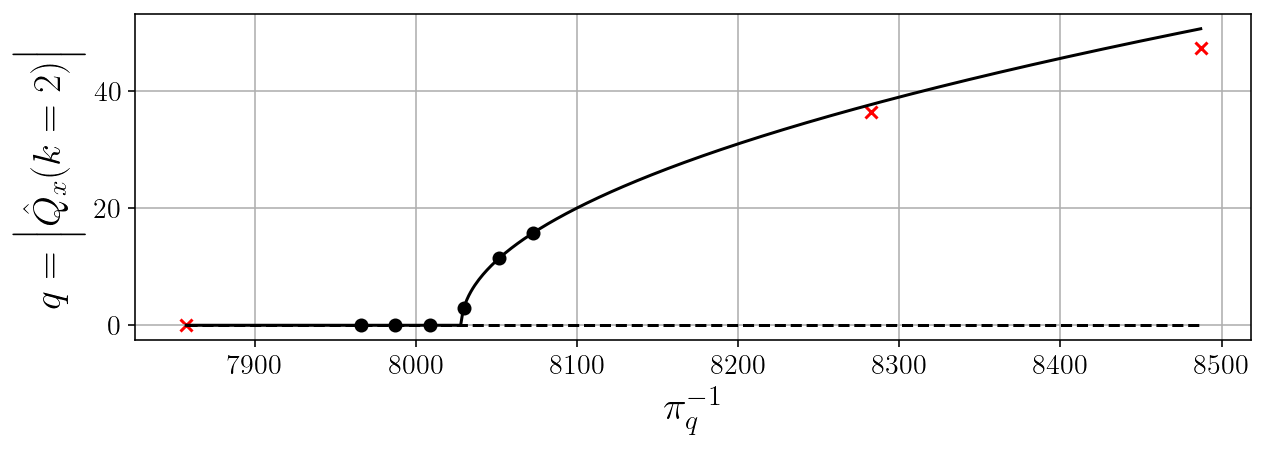

In [568]:
eq_sim = [Q[-1] for Q in CQ_list]
eq_test = [Q[-1] for Q in CQ_test]

plt.figure(figsize=(10, 3))
plt.plot(mu_plt, eq_plt, c='k')
plt.plot(mu_plt, 0*eq_plt, c='k', ls='--')
train_pts = plt.scatter(mu, eq_sim, c='k')
test_pts = plt.scatter(mu_test, eq_test, c='r', marker='x')
plt.grid()
plt.xlabel("$\pi_q^{-1}$")
plt.ylabel(r"$q = \left|\hat{Q}_x(k=2)\right|$")
# plt.legend((train_pts, test_pts), ('Train', 'Test'), fontsize=16)
plt.show()

In [569]:
mu_test

array([7857.48051223, 8282.51169634, 8487.04895709])